# <center>My Anime List Analysis</center>

After cleaning up data we scraped in <i>AnimeListCleanup.ipynb</i>, lets look for some insights from My Anime List:  https://myanimelist.net/. 
<br>This Notebook also produces a Nearest Neighbors Model that recommends shows based on a given title.<br>
<br>Just make a note that this data is from scraping the website January 20th, 2017 so any new titles or changes in scores since then are not taken into account. Also this is only data from TV shows. Movies and OVA's are not included.

## Table of Contents
1. [Genre Analysis](#angen)
2. [Producer Analysis](#anprod)
3. [Studio Analysis](#anstud)
4. [Top Anime](#antop)
5. [Anime Recommender](#anrec)

## Import and Set Up

In [1]:
import json
import cgi
import operator
import ast
import itertools
import collections
from pprint import pprint, pformat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import re
%matplotlib inline

In [2]:
listframe = pd.read_csv('animelist.csv',encoding='utf-8')
pageframe = pd.read_csv('animepage.csv',encoding='utf-8')
recommendationframe = pd.read_csv('animerecommendation.csv',encoding='utf-8')
statsframe = pd.read_csv('animestats.csv',encoding='utf-8')

Turning string entries into json, and string into time data

In [3]:
pageframe.genres = pageframe.genres.apply(lambda x: ast.literal_eval(x))
pageframe.studios = pageframe.studios.apply(lambda x: ast.literal_eval(x))
pageframe.producers = pageframe.producers.apply(lambda x: ast.literal_eval(x))
pageframe.air_start = pd.to_datetime(pageframe.air_start)
pageframe.air_end = pd.to_datetime(pageframe.air_end)
pageframe.status = (pageframe.status.astype('category'))
recommendationframe.recommendations = recommendationframe.recommendations.apply(lambda x: ast.literal_eval(x))

In [4]:
pageframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3797 entries, 0 to 3796
Data columns (total 10 columns):
title        3797 non-null object
episodes     3583 non-null float64
score        3694 non-null float64
num_votes    3797 non-null int64
air_start    3760 non-null datetime64[ns]
air_end      3506 non-null datetime64[ns]
genres       3797 non-null object
producers    3797 non-null object
studios      3797 non-null object
status       3797 non-null category
dtypes: category(1), datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 270.8+ KB


First let's remove anime where it's not worth the time analyzing. This would be anime that hasn't aired for that long(started airing before the middle of 2016), and a lack of score.

In [5]:
pageframe = pageframe[(pageframe.air_start<'2016-06-01') & (~pageframe.score.isnull())]

_ _ _

## Genre Analysis<a id=angen></a>

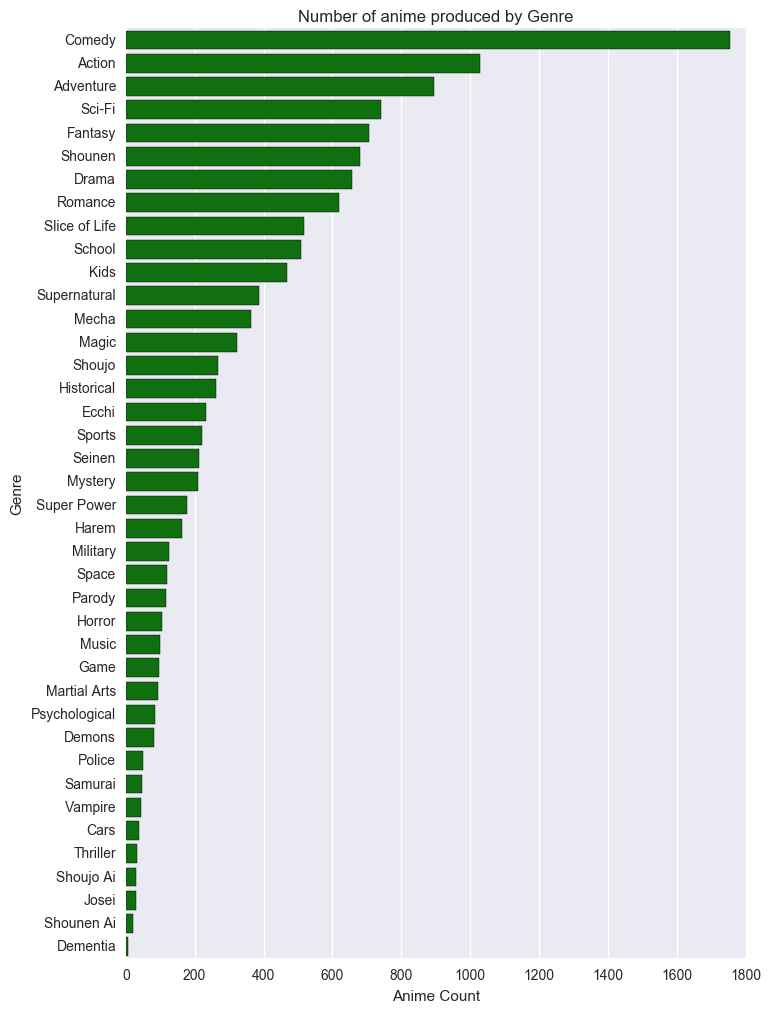

In [6]:
genre_counter = collections.Counter(itertools.chain(*pageframe.genres.values.tolist()))
genres = pd.DataFrame.from_dict(genre_counter, orient='index').reset_index().rename(columns={'index':'genre', 0:'count'})
genres.sort_values('count', ascending=False, inplace=True)
f, ax = plt.subplots(figsize=(8, 12))
sns.barplot(x="count", y="genre", data=genres, color='g')
plt.title('Number of anime produced by Genre')
ax.set(ylabel='Genre',xlabel="Anime Count")
plt.show()

In [7]:
genre_scores_dict = {}
for i,row in pageframe.iterrows():
    title = row['title']
    for g in row['genres']:
        if g in genre_scores_dict:
            genre_scores_dict[g].append(row['score'])
        else:
            genre_scores_dict[g] = [row['score']]
genre_avg_score_dict =  {k: np.nanmean(v) for k, v in genre_scores_dict.items()}
genre_std_score_dict =  {k: np.nanstd(v) for k, v in genre_scores_dict.items()}

In [8]:
a = (sorted(genre_avg_score_dict.items(), key=operator.itemgetter(1),reverse=True))
b = (sorted(genre_std_score_dict.items(), key=operator.itemgetter(1),reverse=False))
html = "<table style='width=100%%'><tr><td>Top Genres By Average Score</td><td>Genres Sorted by Standard Deviation of Score</td></tr>" \
       "<tr><td><pre>%s<pre></td><td><pre>%s<pre></td></tr></table>" % (cgi.escape(pformat(a)), cgi.escape(pformat(b)))
display(HTML(html))

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: cgi.escape is deprecated, use html.escape instead
  app.launch_new_instance()


Top Genres By Average Score,Genres Sorted by Standard Deviation of Score
"[('Thriller', 7.9024242424242432), ('Josei', 7.6234482758620681), ('Psychological', 7.6170238095238103), ('Demons', 7.4158024691358015), ('Mystery', 7.3989473684210525), ('Drama', 7.3551371951219506), ('Seinen', 7.335211267605632), ('Supernatural', 7.3243556701030927), ('Military', 7.3099193548387102), ('Romance', 7.289190938511326), ('Samurai', 7.253043478260869), ('Shounen Ai', 7.2390909090909084), ('Shounen', 7.2259852941176472), ('School', 7.215529411764706), ('Shoujo', 7.2131716417910443), ('Dementia', 7.2100000000000009), ('Martial Arts', 7.197634408602152), ('Space', 7.1695041322314061), ('Shoujo Ai', 7.1690000000000005), ('Super Power', 7.1610674157303373), ('Sports', 7.1271171171171162), ('Action', 7.1011478599221789), ('Vampire', 7.0851162790697684), ('Historical', 7.0842911877394625), ('Harem', 7.0751829268292674), ('Horror', 7.0600961538461542), ('Fantasy', 7.0394059405940599), ('Magic', 7.0392592592592589), ('Slice of Life', 7.0302123552123543), ('Police', 6.9855999999999998), ('Sci-Fi', 6.9806469002695426), ('Game', 6.9631578947368418), ('Adventure', 6.9622879464285718), ('Music', 6.9340816326530605), ('Mecha', 6.9296428571428583), ('Ecchi', 6.9227155172413788), ('Comedy', 6.8783571021106678), ('Parody', 6.8311016949152528), ('Cars', 6.5510526315789477), ('Kids', 6.2574413646055431)]","[('Shoujo Ai', 0.49958883094000406), ('Harem', 0.50035898400971934), ('Martial Arts', 0.55150702205428714), ('Ecchi', 0.57458751780845729), ('Demons', 0.58637169393712507), ('Romance', 0.60462724277116475), ('Mecha', 0.64377631936260016), ('Shoujo', 0.64580103014713097), ('Military', 0.6610310811683151), ('School', 0.66773689643484457), ('Drama', 0.67811542524704915), ('Dementia', 0.68429317025463809), ('Magic', 0.68627600857463344), ('Sci-Fi', 0.68658780649046558), ('Shounen', 0.69150511445190976), ('Space', 0.6973726978703646), ('Seinen', 0.70602941689820775), ('Action', 0.7182875533279468), ('Super Power', 0.72040912685907921), ('Fantasy', 0.72553170328266525), ('Adventure', 0.72594766397919785), ('Mystery', 0.7329065438475808), ('Shounen Ai', 0.74434174147307763), ('Thriller', 0.74518669738378951), ('Supernatural', 0.74599331641640942), ('Horror', 0.76107274391063873), ('Josei', 0.76180038955851825), ('Psychological', 0.79309036860022464), ('Sports', 0.81437632953285211), ('Historical', 0.81820004736528285), ('Game', 0.82745680524299048), ('Vampire', 0.85253213018091334), ('Kids', 0.87292040981469721), ('Slice of Life', 0.8773510902713032), ('Comedy', 0.88381829551929136), ('Samurai', 0.88431960965630763), ('Police', 0.89336030805045297), ('Music', 0.96479017147189217), ('Parody', 0.97585754022330873), ('Cars', 1.0501924371869442)]"


C:\Program Files\Anaconda3\lib\site-packages\seaborn\categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


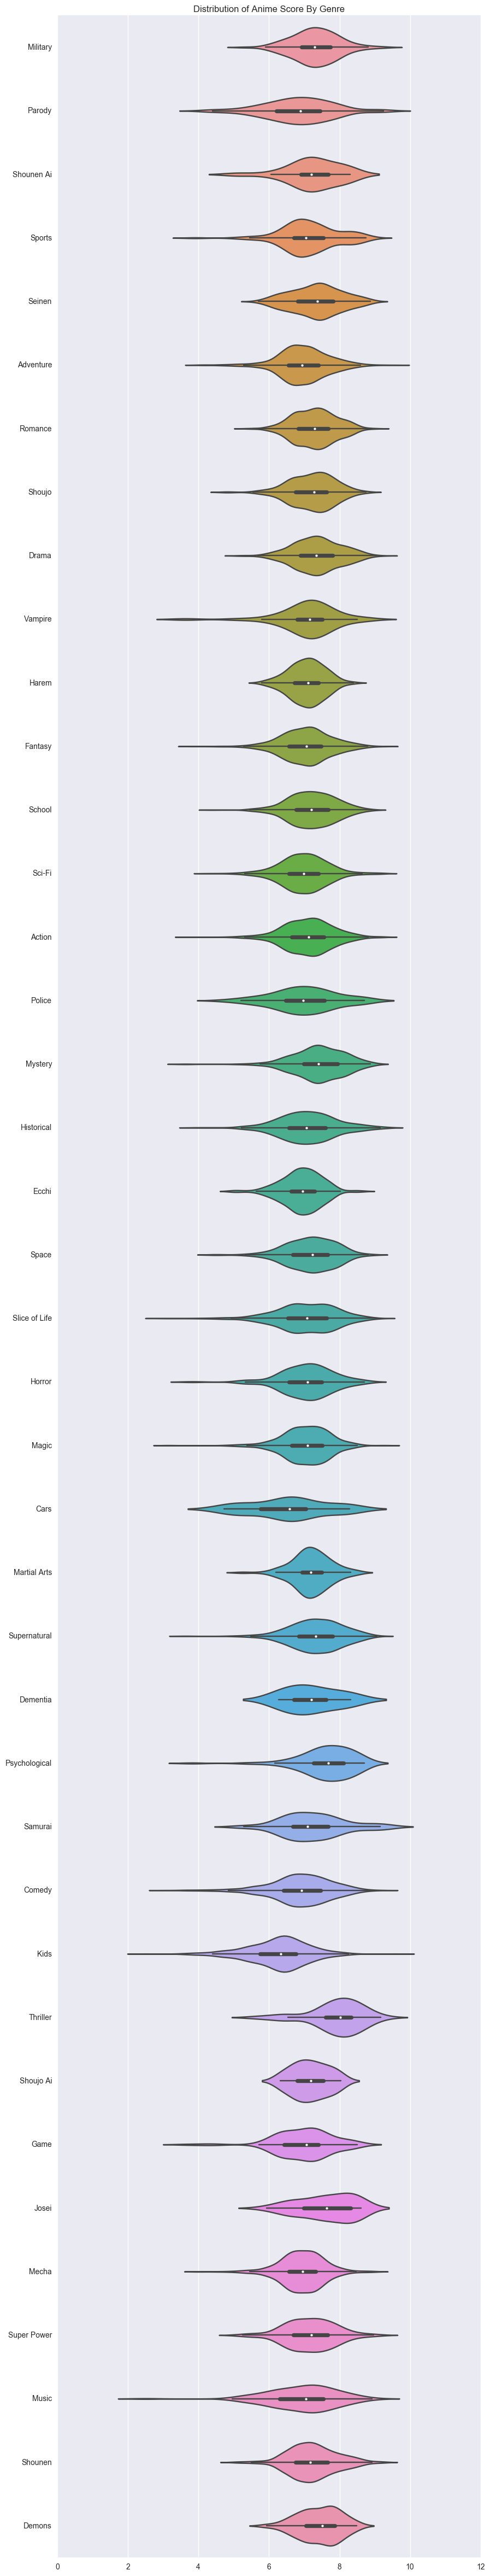

In [9]:
fig = plt.figure(figsize=(10,60))
ax = fig.gca()
#sns.boxplot(data=list(genre_scores_dict.values()),vert=False, showfliers=False)
sns.violinplot(data=list(genre_scores_dict.values()),vert=False, showfliers=False)
plt.title('Distribution of Anime Score By Genre')
ax.set_yticklabels(genre_scores_dict.keys())
plt.show()

One thing you'll note is disproportionately produced the 'Comedy' genre is. In fact it is almost double the next category which is Action. This is because the elements of Comedy is one of those things that can easily be thrown together with many other genres, even with serious genres like Mystery and Action and generally has a wide appeal so it's overproduced. Comedy also has a pretty high standard deviation, which makes sense since, it's over produced and is a genre that's usually a hit or miss.
<br><br>
Another good thing to note is the data about Shounen and Shoujou. Shounen is anime oriented to males and Shoujou is oriented mainly to females. While it's true that Anime tends to orient more towards boys (by comparing number of anime produced). The score and standard deviation aren't really that far off, meaning the shows are pretty comparable in enjoyment.
<br><br>
Also it's interesting to see that as the age demographic goes up so does the the average score. The Kid's genre is all the way at the bottom, Shounen and Shoujou (geared towards teenage audience) are in the middle, and Senein and Josei which are meant for mature audiences are near the top. This might show that the users of My Anime List are probably teens and older.

------------


## Producer Analysis <a id=anprod></a>

We'll only be looking at mainly the top 30 Producers

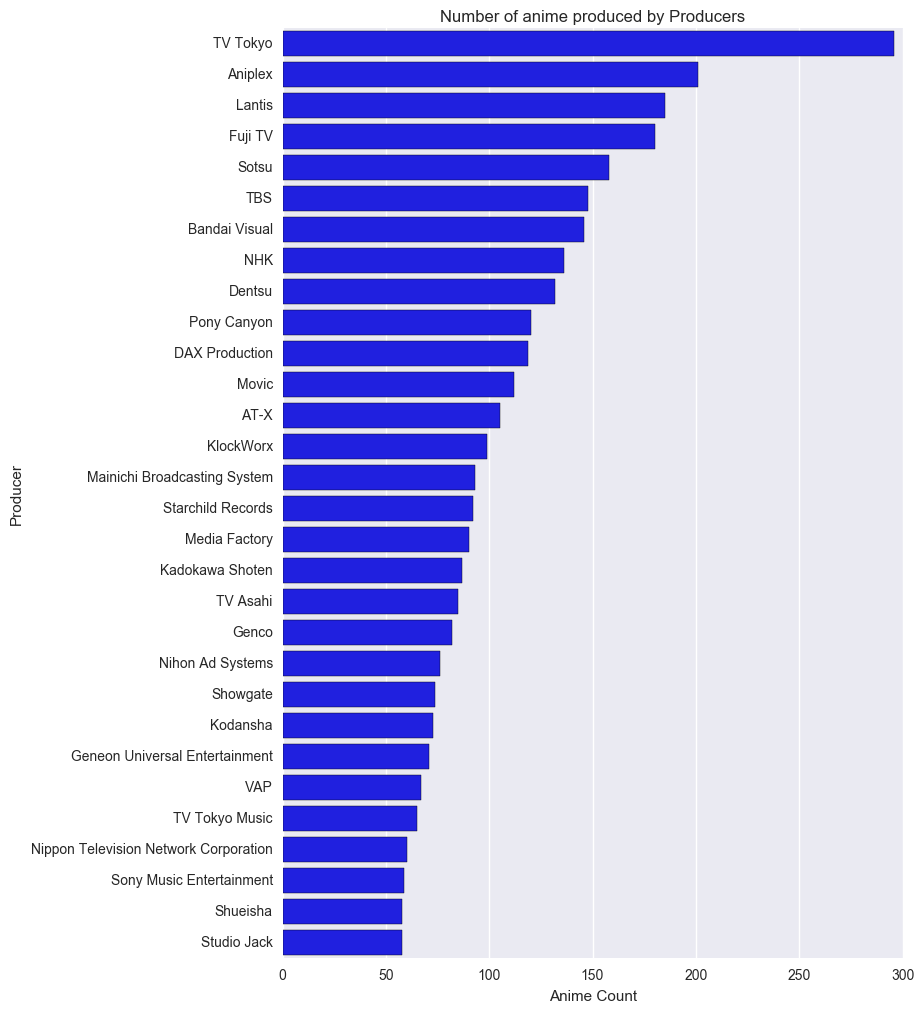

In [10]:
producer_counter = collections.Counter(itertools.chain(*pageframe.producers.values.tolist()))
producers = pd.DataFrame.from_dict(producer_counter, orient='index').reset_index().rename(columns={'index':'producer', 0:'count'})
producers.sort_values('count', ascending=False, inplace=True)
f, ax = plt.subplots(figsize=(8, 12))
sns.barplot(x="count", y="producer", data=producers.head(30), color='b')
plt.title('Number of anime produced by Producers')
ax.set(ylabel='Producer',xlabel="Anime Count")
plt.show()

In [11]:
top_30 = producers.head(30).producer.values
producer_scores_dict = {}
for i,row in pageframe.iterrows():
    title = row['title']
    for g in row['producers']:
        if g in top_30:
            if g in producer_scores_dict:
                producer_scores_dict[g].append(row['score'])
            else:
                producer_scores_dict[g] = [row['score']]
producer_avg_score_dict =  {k: np.nanmean(v) for k, v in producer_scores_dict.items()}
producer_std_score_dict =  {k: np.nanstd(v) for k, v in producer_scores_dict.items()}

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [12]:
a = (sorted(producer_avg_score_dict.items(), key=operator.itemgetter(1),reverse=True))
b = (sorted(producer_std_score_dict.items(), key=operator.itemgetter(1)))
html = "<table style='width=100%%'><tr><td>Top Producers By Average Score</td><td>Producers Sorted by Standard Deviation of Score</td></tr>" \
       "<tr><td><pre>%s<pre></td><td><pre>%s<pre></td></tr></table>" % (cgi.escape(pformat(a)), cgi.escape(pformat(b)))
display(HTML(html))

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: cgi.escape is deprecated, use html.escape instead
  app.launch_new_instance()


Top Producers By Average Score,Producers Sorted by Standard Deviation of Score
"[('Shueisha', 7.8515517241379307), ('Kodansha', 7.6938356164383555), ('Aniplex', 7.6197014925373132), ('Dentsu', 7.5999999999999988), ('Mainichi Broadcasting System', 7.5848387096774195), ('VAP', 7.5397014925373131), ('Movic', 7.5373214285714285), ('Sony Music Entertainment', 7.5055932203389828), ('Nippon Television Network Corporation', 7.4213333333333331), ('Geneon Universal Entertainment', 7.4059154929577469), ('Kadokawa Shoten', 7.373448275862069), ('Showgate', 7.3545945945945963), ('Starchild Records', 7.3506521739130433), ('KlockWorx', 7.3443434343434344), ('Fuji TV', 7.3112777777777778), ('TV Tokyo Music', 7.3066153846153838), ('Bandai Visual', 7.2910273972602742), ('Lantis', 7.2618918918918922), ('Media Factory', 7.2535555555555558), ('Genco', 7.2346341463414623), ('Nihon Ad Systems', 7.2226315789473707), ('Pony Canyon', 7.2140833333333338), ('TV Tokyo', 7.1834121621621616), ('Sotsu', 7.1827848101265817), ('AT-X', 7.1767619047619045), ('Studio Jack', 7.1674137931034476), ('TBS', 7.0816891891891887), ('DAX Production', 7.0634453781512612), ('TV Asahi', 7.054823529411764), ('NHK', 6.7290441176470592)]","[('Starchild Records', 0.52339777114838781), ('TV Tokyo Music', 0.56353356851232617), ('Geneon Universal Entertainment', 0.56502418610775318), ('Media Factory', 0.58158272768008024), ('AT-X', 0.59087263189301764), ('Showgate', 0.59786374021400013), ('TV Asahi', 0.60142890981728991), ('Studio Jack', 0.60271386344521782), ('Movic', 0.61084394509162643), ('Lantis', 0.61238584303122934), ('Shueisha', 0.622128719700624), ('Sotsu', 0.62446521263764898), ('Genco', 0.6267476932778846), ('Bandai Visual', 0.6541267623077337), ('KlockWorx', 0.67472128419502309), ('Nihon Ad Systems', 0.68223774298270723), ('Kodansha', 0.68868870860614984), ('TBS', 0.70542912808303515), ('Kadokawa Shoten', 0.72551024864424341), ('TV Tokyo', 0.72746378593857286), ('Pony Canyon', 0.73915322704805642), ('DAX Production', 0.75588274064479677), ('Aniplex', 0.78156235316724376), ('Mainichi Broadcasting System', 0.78955767241630503), ('Dentsu', 0.78959521658923826), ('Fuji TV', 0.79780673693957538), ('Sony Music Entertainment', 0.81838880815292703), ('VAP', 0.87730756728168757), ('Nippon Television Network Corporation', 1.0454352628876113), ('NHK', 1.2140754644369316)]"


In [13]:
display(HTML('<h3>Shueisha</h3>5 top anime produced by score'))
display(pageframe[(pageframe.producers.apply(lambda x: 'Shueisha' in x))].sort_values('score', ascending=False).head(5))
display(HTML('<h3>Kodansha</h3>5 top anime produced by score'))
display(pageframe[(pageframe.producers.apply(lambda x: 'Kodansha' in x))].sort_values('score', ascending=False).head(5))
display(HTML('<h3>Aniplex</h3>5 top anime produced by score'))
display(pageframe[(pageframe.producers.apply(lambda x: 'Aniplex' in x))].sort_values('score', ascending=False).head(5))

,title,episodes,score,num_votes,air_start,air_end,genres,producers,studios,status
1,Gintama',51.0,9.16,67153,2011-04-04,2012-03-26,"[Action, Sci-Fi, Comedy, Historical, Parody, S...","[TV Tokyo, Aniplex, Dentsu, Trinity Sound, Mir...",[Sunrise],Finished Airing
2,Hunter x Hunter (2011),148.0,9.13,251094,2011-10-02,2014-09-24,"[Action, Adventure, Super Power, Shounen]","[VAP, Nippon Television Network Corporation, S...",[Madhouse],Finished Airing
0,Gintama': Enchousen,13.0,9.10,44356,2012-10-04,2013-03-28,"[Action, Comedy, Historical, Parody, Samurai, ...","[TV Tokyo, Aniplex, Dentsu, Shueisha, Miracle ...",[Sunrise],Finished Airing
13,Gintama,201.0,9.04,108333,2006-04-04,2010-03-25,"[Action, Sci-Fi, Comedy, Historical, Parody, S...","[TV Tokyo, Aniplex, Dentsu, Trinity Sound, Aud...",[Sunrise],Finished Airing
3794,One Punch Man,12.0,8.80,398205,2015-10-05,2015-12-21,"[Action, Sci-Fi, Comedy, Parody, Super Power, ...","[TV Tokyo, Bandai Visual, Lantis, Asatsu DK, B...",[Madhouse],Finished Airing


,title,episodes,score,num_votes,air_start,air_end,genres,producers,studios,status
10,Shigatsu wa Kimi no Uso,22.0,8.92,254652,2014-10-10,2015-03-20,"[Drama, Music, Romance, School, Shounen]","[Aniplex, Dentsu, Kodansha, Fuji TV, Kyoraku I...",[A-1 Pictures],Finished Airing
9,Mushishi Zoku Shou 2nd Season,10.0,8.87,33583,2014-10-19,2014-12-21,"[Adventure, Fantasy, Historical, Mystery, Sein...","[Aniplex, Kodansha, Delfi Sound]",[Artland],Finished Airing
3795,Mushishi Zoku Shou,10.0,8.80,44843,2014-04-05,2014-06-21,"[Slice of Life, Adventure, Fantasy, Supernatur...","[Aniplex, Kodansha, Delfi Sound]",[Artland],Finished Airing
3793,Monogatari Series: Second Season,26.0,8.79,114920,2013-07-07,2013-12-29,"[Mystery, Comedy, Supernatural, Romance, Vampire]","[Aniplex, Kodansha, Cyclone Graphics inc]",[Shaft],Finished Airing
3789,Hajime no Ippo: New Challenger,26.0,8.75,58655,2009-01-07,2009-07-01,"[Comedy, Sports, Drama, Shounen]","[VAP, Kodansha, Nippon Television Network Corp...",[Madhouse],Finished Airing


,title,episodes,score,num_votes,air_start,air_end,genres,producers,studios,status
6,Fullmetal Alchemist: Brotherhood,64.0,9.26,511176,2009-04-05,2010-07-04,"[Action, Military, Adventure, Drama, Magic, Fa...","[Aniplex, Square Enix, Mainichi Broadcasting S...",[Bones],Finished Airing
5,Gintama°,51.0,9.25,42937,2015-04-08,2016-03-30,"[Action, Comedy, Historical, Parody, Samurai, ...","[TV Tokyo, Aniplex, Dentsu]",[Bandai Namco Pictures],Finished Airing
1,Gintama',51.0,9.16,67153,2011-04-04,2012-03-26,"[Action, Sci-Fi, Comedy, Historical, Parody, S...","[TV Tokyo, Aniplex, Dentsu, Trinity Sound, Mir...",[Sunrise],Finished Airing
0,Gintama': Enchousen,13.0,9.10,44356,2012-10-04,2013-03-28,"[Action, Comedy, Historical, Parody, Samurai, ...","[TV Tokyo, Aniplex, Dentsu, Shueisha, Miracle ...",[Sunrise],Finished Airing
13,Gintama,201.0,9.04,108333,2006-04-04,2010-03-25,"[Action, Sci-Fi, Comedy, Historical, Parody, S...","[TV Tokyo, Aniplex, Dentsu, Trinity Sound, Aud...",[Sunrise],Finished Airing


It's interesting to see Aniplex at 3rd on average score and 2nd number of anime produced by producer. But it's important to remember its Studio's that create anime not Producers. This means that a Production company is tested on it's skill at making investments not making anime. And also while usually there are only one or two Studios involved in making anime, it's not surprising to see many studios involved in the process. Hence the quality of an anime probably depends more on the Studio than the Producer.

------------------------

## Studio Analysis<a id=anstud></a>

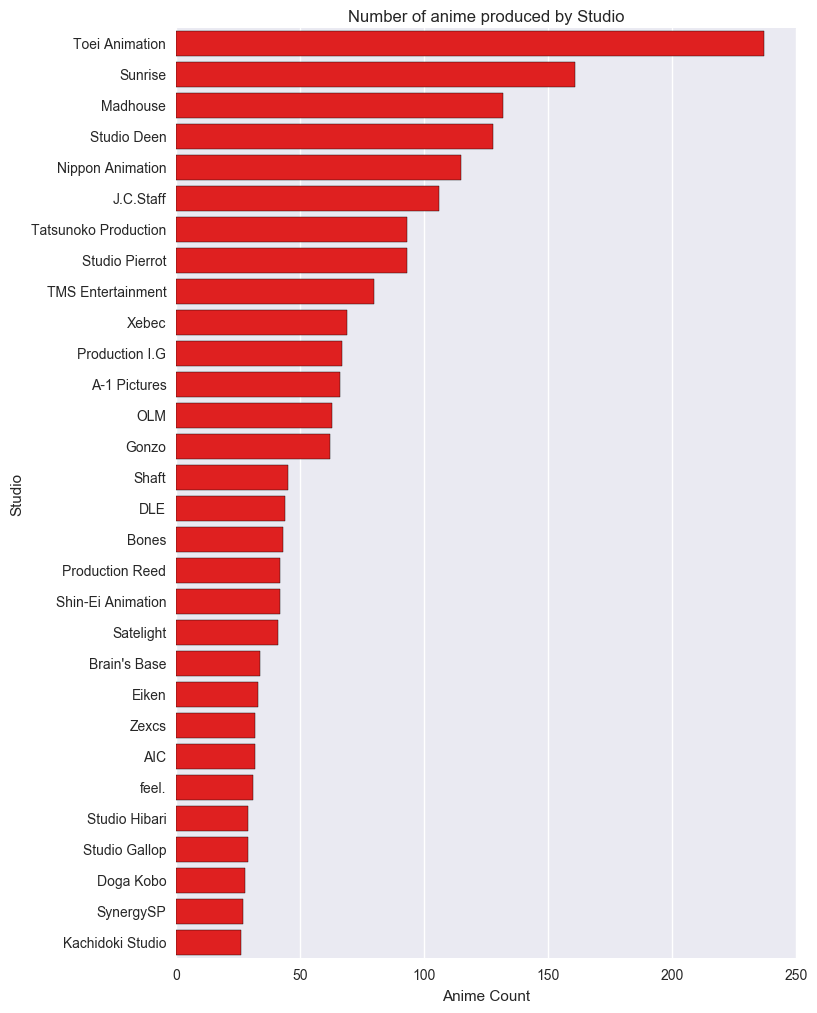

In [14]:
studio_counter = collections.Counter(itertools.chain(*pageframe.studios.values.tolist()))
studios = pd.DataFrame.from_dict(studio_counter, orient='index').reset_index().rename(columns={'index':'studio', 0:'count'})
studios.sort_values('count', ascending=False, inplace=True)
f, ax = plt.subplots(figsize=(8, 12))
sns.barplot(x="count", y="studio", data=studios.head(30), color='r')
plt.title('Number of anime produced by Studio')
ax.set(ylabel='Studio',xlabel="Anime Count")
plt.show()

In [15]:
top_30 = studios.head(30).studio.values
studio_scores_dict = {}
for i,row in pageframe.iterrows():
    title = row['title']
    for g in row['studios']:
        if g in top_30:
            if g in studio_scores_dict:
                studio_scores_dict[g].append(row['score'])
            else:
                studio_scores_dict[g] = [row['score']]
studio_avg_score_dict =  {k: np.nanmean(v) for k, v in studio_scores_dict.items()}
studio_std_score_dict =  {k: np.nanstd(v) for k, v in studio_scores_dict.items()}

In [16]:
a = (sorted(studio_avg_score_dict.items(), key=operator.itemgetter(1),reverse=True))
b = (sorted(studio_std_score_dict.items(), key=operator.itemgetter(1)))
# Try the following in IPython:
html = "<table style='width=100%%'><tr><td>Top Studios By Average Score</td><td>Studios Sorted by Standard Deviation of Score</td></tr>" \
       "<tr><td><pre>%s<pre></td><td><pre>%s<pre></td></tr></table>" % (cgi.escape(pformat(a)), cgi.escape(pformat(b)))
display(HTML(html))

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: cgi.escape is deprecated, use html.escape instead


Top Studios By Average Score,Studios Sorted by Standard Deviation of Score
"[('Bones', 7.6313953488372102), ('A-1 Pictures', 7.5463636363636368), ('Shaft', 7.4957777777777794), ('Production I.G', 7.4620895522388064), (""Brain's Base"", 7.4314705882352934), ('Madhouse', 7.403106060606059), ('J.C.Staff', 7.3986792452830201), ('Sunrise', 7.2327950310559004), ('Studio Pierrot', 7.2040860215053764), ('Gonzo', 7.2038709677419357), ('Studio Deen', 7.1414062500000002), ('Satelight', 7.1312195121951216), ('AIC', 7.1303125000000005), ('Studio Gallop', 7.0920689655172415), ('TMS Entertainment', 7.0842499999999999), ('SynergySP', 7.0803703703703711), ('Doga Kobo', 7.008571428571428), ('Xebec', 7.0053623188405796), ('Toei Animation', 6.9801265822784808), ('Studio Hibari', 6.9734482758620686), ('Nippon Animation', 6.9706086956521736), ('feel.', 6.9341935483870989), ('Zexcs', 6.8831249999999997), ('OLM', 6.853650793650794), ('Tatsunoko Production', 6.7723655913978495), ('Production Reed', 6.699523809523809), ('Shin-Ei Animation', 6.6214285714285719), ('Eiken', 6.4272727272727268), ('DLE', 5.5713636363636363), ('Kachidoki Studio', 5.4123076923076923)]","[('AIC', 0.40273661038419389), ('Zexcs', 0.50696669947344664), ('Xebec', 0.50701622107700139), ('Gonzo', 0.51286153208503737), ('Eiken', 0.54643346500780932), ('OLM', 0.55156718017427564), ('Bones', 0.61240502403780039), ('TMS Entertainment', 0.62172496933933741), ('Tatsunoko Production', 0.63899180981417636), ('Production Reed', 0.63953462388473714), ('Nippon Animation', 0.64435243793456065), ('Toei Animation', 0.64956102087633438), ('J.C.Staff', 0.6517249614816808), ('Satelight', 0.65192097052817399), ('feel.', 0.66485396986759382), ('A-1 Pictures', 0.6773984020067676), ('Sunrise', 0.70121209272339335), ('Studio Pierrot', 0.7065960147666922), ('Shaft', 0.70890679183244742), ('Doga Kobo', 0.73533138440974977), ('Shin-Ei Animation', 0.74302974185352211), ('Studio Deen', 0.77195949373068629), ('Studio Hibari', 0.77674509137797965), ('Madhouse', 0.78788279063668543), (""Brain's Base"", 0.811179723151778), ('Production I.G', 0.81924890485114432), ('Studio Gallop', 0.85838412473005643), ('Kachidoki Studio', 0.88113697395121571), ('SynergySP', 1.0047239587051555), ('DLE', 1.0727822597617394)]"


In [17]:
display(HTML('<h3>Bones</h3>5 top anime created by score'))
display(pageframe[(pageframe.studios.apply(lambda x: 'Bones' in x))].sort_values('score', ascending=False).head(5))
display(HTML('<h3>A-1 Pictures</h3>5 top anime created by score'))
display(pageframe[(pageframe.studios.apply(lambda x: 'A-1 Pictures' in x))].sort_values('score', ascending=False).head(5))
display(HTML('<h3>Shaft</h3>5 top anime created by score'))
display(pageframe[(pageframe.studios.apply(lambda x: 'Shaft' in x))].sort_values('score', ascending=False).head(5))
display(HTML('<h3>Production I.G</h3>5 top anime created by score'))
display(pageframe[(pageframe.studios.apply(lambda x: 'Production I.G' in x))].sort_values('score', ascending=False).head(5))
display(HTML('<h3>Brain\'s Base</h3>5 top anime created by score'))
display(pageframe[(pageframe.studios.apply(lambda x: "Brain's Base" in x))].sort_values('score', ascending=False).head(5))
display(HTML('<h3>Madhouse</h3>5 top anime created by score'))
display(pageframe[(pageframe.studios.apply(lambda x: 'Madhouse' in x))].sort_values('score', ascending=False).head(5))

,title,episodes,score,num_votes,air_start,air_end,genres,producers,studios,status
6,Fullmetal Alchemist: Brotherhood,64.0,9.26,511176,2009-04-05,2010-07-04,"[Action, Military, Adventure, Drama, Magic, Fa...","[Aniplex, Square Enix, Mainichi Broadcasting S...",[Bones],Finished Airing
3733,Noragami Aragoto,13.0,8.48,187904,2015-10-03,2015-12-26,"[Action, Adventure, Shounen, Supernatural]","[Dentsu, Shochiku, Kodansha, Ai Addiction, Ave...",[Bones],Finished Airing
3717,Ouran Koukou Host Club,26.0,8.39,277960,2006-04-05,2006-09-27,"[Comedy, Harem, Romance, School, Shoujo]","[VAP, Hakusensha, Nippon Television Network Co...",[Bones],Finished Airing
3700,Boku no Hero Academia,13.0,8.35,184244,2016-04-03,2016-06-26,"[Action, Comedy, Super Power, School, Shounen]","[Dentsu, Mainichi Broadcasting System, Movic, ...",[Bones],Finished Airing
3691,Fullmetal Alchemist,51.0,8.32,396066,2003-10-04,2004-10-02,"[Action, Adventure, Comedy, Drama, Fantasy, Ma...","[Aniplex, Dentsu, Square Enix, Mainichi Broadc...",[Bones],Finished Airing


,title,episodes,score,num_votes,air_start,air_end,genres,producers,studios,status
10,Shigatsu wa Kimi no Uso,22.0,8.92,254652,2014-10-10,2015-03-20,"[Drama, Music, Romance, School, Shounen]","[Aniplex, Dentsu, Kodansha, Fuji TV, Kyoraku I...",[A-1 Pictures],Finished Airing
3774,Boku dake ga Inai Machi,12.0,8.64,272639,2016-01-08,2016-03-25,"[Mystery, Psychological, Seinen, Supernatural]","[Aniplex, Dentsu, Kadokawa Shoten, Fuji TV, DA...",[A-1 Pictures],Finished Airing
3773,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,11.0,8.61,298236,2011-04-15,2011-06-24,"[Slice of Life, Supernatural, Drama]","[Aniplex, Dentsu, Fuji TV, Fuji Pacific Music ...",[A-1 Pictures],Finished Airing
3765,Uchuu Kyoudai,99.0,8.59,21357,2012-04-01,2014-03-22,"[Comedy, Sci-Fi, Seinen, Slice of Life, Space]","[Aniplex, Dentsu, YTV, Trinity Sound]",[A-1 Pictures],Finished Airing
3750,Shinsekai yori,25.0,8.52,120632,2012-09-29,2013-03-23,"[Drama, Horror, Mystery, Sci-Fi, Supernatural]","[Aniplex, TV Asahi, Pony Canyon]",[A-1 Pictures],Finished Airing


,title,episodes,score,num_votes,air_start,air_end,genres,producers,studios,status
3793,Monogatari Series: Second Season,26.0,8.79,114920,2013-07-07,2013-12-29,"[Mystery, Comedy, Supernatural, Romance, Vampire]","[Aniplex, Kodansha, Cyclone Graphics inc]",[Shaft],Finished Airing
3747,Mahou Shoujo Madoka★Magica,12.0,8.51,294434,2011-01-07,2011-04-22,"[Drama, Magic, Psychological, Thriller]","[Aniplex, Mainichi Broadcasting System, Movic,...",[Shaft],Finished Airing
20,Owarimonogatari,12.0,8.43,52715,2015-10-04,2015-12-20,"[Mystery, Comedy, Supernatural]",[Aniplex],[Shaft],Finished Airing
3714,Bakemonogatari,15.0,8.38,272610,2009-07-03,2010-06-25,"[Mystery, Supernatural, Romance, Vampire]","[Aniplex, Kodansha]",[Shaft],Finished Airing
43,Nisemonogatari,11.0,8.21,163170,2012-01-08,2012-03-18,"[Comedy, Mystery, Supernatural]","[Aniplex, Kodansha, Rakuonsha]",[Shaft],Finished Airing


,title,episodes,score,num_votes,air_start,air_end,genres,producers,studios,status
11,Haikyuu!! Second Season,25.0,8.92,115893,2015-10-04,2016-03-27,"[Comedy, Drama, School, Shounen, Sports]",[TOHO animation],[Production I.G],Finished Airing
3783,Haikyuu!!,25.0,8.68,175816,2014-04-06,2014-09-21,"[Comedy, Drama, School, Shounen, Sports]","[Mainichi Broadcasting System, TOHO animation]",[Production I.G],Finished Airing
3770,Kuroko no Basket 3rd Season,25.0,8.61,116007,2015-01-11,2015-06-30,"[Comedy, Sports, School, Shounen]","[Bandai Visual, Lantis, Nihon Ad Systems, Banp...",[Production I.G],Finished Airing
3761,Ghost in the Shell: Stand Alone Complex 2nd GIG,26.0,8.57,59181,2004-01-01,2005-01-08,"[Action, Military, Sci-Fi, Mystery, Police, Me...","[Bandai Visual, Dentsu, Victor Entertainment, ...",[Production I.G],Finished Airing
3760,Kuroko no Basket 2nd Season,25.0,8.57,162344,2013-10-06,2014-03-30,"[Comedy, Sports, School, Shounen]","[Bandai Visual, Lantis, Nihon Ad Systems, Banp...",[Production I.G],Finished Airing


,title,episodes,score,num_votes,air_start,air_end,genres,producers,studios,status
3788,Natsume Yuujinchou Shi,13.0,8.75,48263,2012-01-03,2012-03-27,"[Slice of Life, Supernatural, Drama, Fantasy, ...","[TV Tokyo, Aniplex, Nihon Ad Systems, Hakusens...",[Brain's Base],Finished Airing
3779,Natsume Yuujinchou San,13.0,8.67,54043,2011-07-05,2011-09-27,"[Drama, Fantasy, Shoujo, Slice of Life, Supern...","[Aniplex, Sakura Create]",[Brain's Base],Finished Airing
3772,Zoku Natsume Yuujinchou,13.0,8.64,62958,2009-01-06,2009-03-31,"[Drama, Fantasy, Shoujo, Slice of Life, Supern...","[Aniplex, Nihon Ad Systems]",[Brain's Base],Finished Airing
16,Baccano!,13.0,8.54,180521,2007-07-27,2007-11-02,"[Action, Comedy, Supernatural, Historical, Mys...","[Aniplex, Sakura Create, Happinet Pictures]",[Brain's Base],Finished Airing
25,Ookami to Koushinryou II,12.0,8.46,129786,2009-07-09,2009-09-24,"[Adventure, Fantasy, Historical, Romance]","[Imagin, flying DOG]",[Brain's Base],Finished Airing


,title,episodes,score,num_votes,air_start,air_end,genres,producers,studios,status
2,Hunter x Hunter (2011),148.0,9.13,251094,2011-10-02,2014-09-24,"[Action, Adventure, Super Power, Shounen]","[VAP, Nippon Television Network Corporation, S...",[Madhouse],Finished Airing
8,Hajime no Ippo,75.0,8.83,87278,2000-10-04,2002-03-27,"[Comedy, Sports, Drama, Shounen]",[VAP],[Madhouse],Finished Airing
3794,One Punch Man,12.0,8.80,398205,2015-10-05,2015-12-21,"[Action, Sci-Fi, Comedy, Parody, Super Power, ...","[TV Tokyo, Bandai Visual, Lantis, Asatsu DK, B...",[Madhouse],Finished Airing
3789,Hajime no Ippo: New Challenger,26.0,8.75,58655,2009-01-07,2009-07-01,"[Comedy, Sports, Drama, Shounen]","[VAP, Kodansha, Nippon Television Network Corp...",[Madhouse],Finished Airing
3784,Monster,74.0,8.71,89747,2004-04-07,2005-09-28,"[Drama, Horror, Mystery, Police, Psychological...","[VAP, Shogakukan Productions, Nippon Televisio...",[Madhouse],Finished Airing


----------------------

## Top Anime <a id=antop></a>

There are really two ways to rank shows. One is by popularity. We measure this by user participation, either through the number of members or the number of votes. The second is the Score. This is on a voted scale between 1-10 by voters/members.

In [18]:
#Filtering List Frame and Stats frame to remove shows that haven't been rated or started airing after mid 2016.
statsframe = statsframe[statsframe.title.isin(pageframe.title)]
listframe = listframe[listframe.title.isin(pageframe.title)]

In [19]:
display(HTML('<h3><i>Top 20 Anime by Number of Members</i></h3>'))
display(listframe.sort_values('members', ascending=False).head(20).reset_index(drop=True))

,title,ranking,score,members,episodes,link
0,Death Note,28.0,8.71,1049456,37.0,https://myanimelist.net/anime/1535/Death_Note
1,Shingeki no Kyojin,62.0,8.53,933243,25.0,https://myanimelist.net/anime/16498/Shingeki_n...
2,Sword Art Online,482.0,7.80,928519,25.0,https://myanimelist.net/anime/11757/Sword_Art_...
3,Fullmetal Alchemist: Brotherhood,1.0,9.26,824466,64.0,https://myanimelist.net/anime/5114/Fullmetal_A...
4,Angel Beats!,113.0,8.38,744300,13.0,https://myanimelist.net/anime/6547/Angel_Beats
5,Code Geass: Hangyaku no Lelouch,16.0,8.82,738964,25.0,https://myanimelist.net/anime/1575/Code_Geass_...
6,Naruto,460.0,7.82,705999,220.0,https://myanimelist.net/anime/20/Naruto
7,Steins;Gate,4.0,9.17,702136,24.0,https://myanimelist.net/anime/9253/Steins_Gate
8,Mirai Nikki (TV),282.0,8.05,684973,26.0,https://myanimelist.net/anime/10620/Mirai_Nikk...
9,Toradora!,95.0,8.45,659082,25.0,https://myanimelist.net/anime/4224/Toradora


In [20]:
display(HTML('<h3><i>Top 20 Anime by Score</i></h3>'))
display(listframe[(listframe.members>1000)].sort_values(by =['score','members'], ascending=False)
        .head(20).reset_index(drop=True))

,title,ranking,score,members,episodes,link
0,Fullmetal Alchemist: Brotherhood,1.0,9.26,824466,64.0,https://myanimelist.net/anime/5114/Fullmetal_A...
1,Gintama°,2.0,9.25,121675,51.0,https://myanimelist.net/anime/28977/Gintama°
2,Steins;Gate,4.0,9.17,702136,24.0,https://myanimelist.net/anime/9253/Steins_Gate
3,Gintama',5.0,9.16,156924,51.0,https://myanimelist.net/anime/9969/Gintama
4,Hunter x Hunter (2011),6.0,9.13,448900,148.0,https://myanimelist.net/anime/11061/Hunter_x_H...
5,Gintama': Enchousen,7.0,9.10,84972,13.0,https://myanimelist.net/anime/15417/Gintama__E...
6,Clannad: After Story,9.0,9.06,469902,24.0,https://myanimelist.net/anime/4181/Clannad__Af...
7,Gintama,10.0,9.04,347710,201.0,https://myanimelist.net/anime/918/Gintama
8,Code Geass: Hangyaku no Lelouch R2,11.0,8.97,592200,25.0,https://myanimelist.net/anime/2904/Code_Geass_...
9,Shigatsu wa Kimi no Uso,13.0,8.92,443090,22.0,https://myanimelist.net/anime/23273/Shigatsu_w...


In [21]:
display(HTML('<h3><i>Top 20 Anime by Calculated Score</i></h3>'))
#filtering number of votes so we know that there is a reasonable sample size
display(statsframe[(statsframe.num_votes>500)].sort_values('score', ascending=False)
        .head(20).reset_index(drop=True)[['title','score','stdev','num_votes']])
display(HTML('*Note: This is from using the score directly calculated from the raw vote data. My Anime List uses its own scoring system when ranking on its website. To use this score, look at the score on list frame or page frame'))

,title,score,stdev,num_votes
0,Fullmetal Alchemist: Brotherhood,9.199562,1.106454,538659
1,Steins;Gate,9.104526,1.242112,416977
2,Gintama': Enchousen,9.076630,1.358325,45713
3,Gintama°,9.074485,1.656560,51930
4,Gintama',9.060988,1.441448,72473
5,Hunter x Hunter (2011),9.058179,1.164326,272675
6,Clannad: After Story,9.025626,1.394203,297978
7,Code Geass: Hangyaku no Lelouch R2,8.958917,1.317956,423900
8,Haikyuu!! Second Season,8.910508,1.060366,120513
9,Shigatsu wa Kimi no Uso,8.879134,1.351037,262546


In [22]:
display(HTML('Comparing the standard deviations of the shows above with the rest of the standard deviations show most of them with in the bottom 25th Percentile. This means there\'s not much variation in opinion, most people find these shows to be solid.'))
display(statsframe[statsframe.num_votes>500].stdev.describe())

count    2245.000000
mean        1.630683
std         0.212012
min         1.060366
25%         1.496615
50%         1.615594
75%         1.749520
max         3.295513
Name: stdev, dtype: float64

Lets look for some possible gems. All the shows above had more than 45,000 votes, indicating their popularity. Let's look at top shows that have less than 40,000 votes

In [23]:
display(HTML('<h3><i>Top 20 Anime by Calculated Score With Less than 40,000 Votes</i></h3>'))
display(statsframe[(statsframe.num_votes.between(500,40000))].sort_values('score', ascending=False)
        .head(20).reset_index(drop=True)[['title','score','stdev','num_votes']])
display(HTML('*Note: This is from using the score directly calculated from the raw vote data. My Anime List uses its own scoring system when ranking on its website. To use this score, look at the score on list frame or page frame'))

,title,score,stdev,num_votes
0,Mushishi Zoku Shou 2nd Season,8.855883,1.167762,34583
1,Major S5,8.570813,1.239656,18570
2,Kingdom 2nd Season,8.539719,1.234838,16277
3,Aria The Origination,8.531574,1.707301,15994
4,Shouwa Genroku Rakugo Shinjuu,8.521196,1.287393,30194
5,Major S6,8.494597,1.285216,15918
6,Ashita no Joe 2,8.493786,1.629701,2414
7,Cross Game,8.460279,1.383474,25100
8,Diamond no Ace: Second Season,8.458122,1.217514,21658
9,Romeo no Aoi Sora,8.443144,1.497162,6068


It's interesting to see the series Major take 6 out of the 20 spots. I never heard of it. After looking it up it makes more sense why it doesn't really make it as high. The show is about baseball classifying it as a Sports Genre. If you go back to the <b>Genre Analysis</b> you can see that Sports is very low on the Number of Anime Produced by Genre. So even though it might be a great series, it's appeal/popularity is very limited among anime viewers since not many would look for a Sports show to begin with.

Another thing that might be of interest are popular anime's that stopped airing after 2007. The popularity and expansive reach of Internet is a relatively recent phenomen. myanimelist.net didn't start being created until 2004 with only 2,000 users in 2007. Because shows that currently air are more likely to get attention, old anime series (unless they have reruns) will have a harder time getting votes. Let's look at anime airing before 2007.

In [24]:
before_date = '2007-1-1' #Change if you want to look anime finishing by a different airing
display(HTML('<h3><i>Top 20 Anime that Finished Airing before 2007 by Score</i></h3>'))
display(pageframe[(pageframe.air_end<before_date)& (pageframe.num_votes>500)].sort_values(by=['score','num_votes'], ascending=False).head(20).reset_index(drop=True))

,title,episodes,score,num_votes,air_start,air_end,genres,producers,studios,status
0,Hajime no Ippo,75.0,8.83,87278,2000-10-04,2002-03-27,"[Comedy, Sports, Drama, Shounen]",[VAP],[Madhouse],Finished Airing
1,Cowboy Bebop,26.0,8.82,272528,1998-04-03,1999-04-24,"[Action, Sci-Fi, Adventure, Space, Comedy, Drama]",[Bandai Visual],[Sunrise],Finished Airing
2,Mushishi,26.0,8.77,118888,2005-10-23,2006-06-19,"[Adventure, Fantasy, Historical, Mystery, Sein...","[Avex Entertainment, Marvelous Entertainment, ...",[Artland],Finished Airing
3,Great Teacher Onizuka,43.0,8.76,149955,1999-06-30,2000-09-17,"[Comedy, Drama, School, Shounen, Slice of Life]","[Aniplex, Fuji TV]",[Studio Pierrot],Finished Airing
4,Monster,74.0,8.71,89747,2004-04-07,2005-09-28,"[Drama, Horror, Mystery, Police, Psychological...","[VAP, Shogakukan Productions, Nippon Televisio...",[Madhouse],Finished Airing
5,Ghost in the Shell: Stand Alone Complex 2nd GIG,26.0,8.57,59181,2004-01-01,2005-01-08,"[Action, Military, Sci-Fi, Mystery, Police, Me...","[Bandai Visual, Dentsu, Victor Entertainment, ...",[Production I.G],Finished Airing
6,Slam Dunk,101.0,8.56,42705,1993-10-16,1996-03-23,"[Comedy, Sports, Drama, School, Shounen]","[TV Asahi, Animax]",[Toei Animation],Finished Airing
7,Ashita no Joe 2,47.0,8.51,2304,1980-10-13,1981-08-31,"[Drama, Sports]",[Annapuru],[Tokyo Movie Shinsha],Finished Airing
8,Samurai Champloo,26.0,8.50,231483,2004-05-20,2005-03-19,"[Action, Adventure, Comedy, Historical, Samura...","[Victor Entertainment, Fuji TV, Barnum Studio,...",[Manglobe],Finished Airing
9,Hunter x Hunter,62.0,8.48,88081,1999-10-16,2001-03-31,"[Action, Adventure, Shounen, Super Power]",[Fuji TV],[Nippon Animation],Finished Airing


In [25]:
before_date = '2007-1-1' #Change if you want to look anime finishing by a different airing
display(HTML('<h3><i>Top 20 Anime that Finished Airing before 2007 by Number of Votes</i></h3>'))
display(pageframe[(pageframe.air_end<before_date)& (pageframe.num_votes>500)].sort_values(by=['num_votes','score'], ascending=False).head(20).reset_index(drop=True))

,title,episodes,score,num_votes,air_start,air_end,genres,producers,studios,status
0,Elfen Lied,13.0,7.84,413148,2004-07-25,2004-10-17,"[Action, Horror, Psychological, Supernatural, ...","[VAP, Genco, A Line]",[Arms],Finished Airing
1,Fullmetal Alchemist,51.0,8.32,396066,2003-10-04,2004-10-02,"[Action, Adventure, Comedy, Drama, Fantasy, Ma...","[Aniplex, Dentsu, Square Enix, Mainichi Broadc...",[Bones],Finished Airing
2,Neon Genesis Evangelion,26.0,8.32,279283,1995-10-04,1996-03-27,"[Action, Sci-Fi, Dementia, Psychological, Dram...","[TV Tokyo, Kadokawa Shoten, Nihon Ad Systems, ...","[Gainax, Tatsunoko Production]",Finished Airing
3,Ouran Koukou Host Club,26.0,8.39,277960,2006-04-05,2006-09-27,"[Comedy, Harem, Romance, School, Shoujo]","[VAP, Hakusensha, Nippon Television Network Co...",[Bones],Finished Airing
4,Cowboy Bebop,26.0,8.82,272528,1998-04-03,1999-04-24,"[Action, Sci-Fi, Adventure, Space, Comedy, Drama]",[Bandai Visual],[Sunrise],Finished Airing
5,Dragon Ball Z,291.0,8.32,271349,1989-04-26,1996-01-31,"[Action, Adventure, Comedy, Fantasy, Martial A...",[Fuji TV],[Toei Animation],Finished Airing
6,Suzumiya Haruhi no Yuuutsu,14.0,8.05,258662,2006-04-03,2006-07-03,"[Comedy, Mystery, Parody, School, Sci-Fi, Slic...","[Lantis, Kadokawa Shoten, Kadokawa Pictures Ja...",[Kyoto Animation],Finished Airing
7,Samurai Champloo,26.0,8.50,231483,2004-05-20,2005-03-19,"[Action, Adventure, Comedy, Historical, Samura...","[Victor Entertainment, Fuji TV, Barnum Studio,...",[Manglobe],Finished Airing
8,Fate/stay night,24.0,7.57,217568,2006-01-07,2006-06-17,"[Action, Supernatural, Magic, Romance, Fantasy]","[Geneon Universal Entertainment, Frontier Work...",[Studio Deen],Finished Airing
9,Zero no Tsukaima,13.0,7.61,217274,2006-07-03,2006-09-25,"[Action, Adventure, Harem, Comedy, Magic, Roma...","[Genco, Media Factory, Shochiku, Bushiroad, Ha...",[J.C.Staff],Finished Airing


## Anime Recommender<a id=anrec></a>

Let's make a model that recommends anime based on Genre, Studio and Score

In [26]:
preprocess_frame = pageframe[['title','score','genres','studios']]
preprocess_frame = preprocess_frame.merge(listframe[['title','link']],how='left',on='title')
preprocess_frame.head()

,title,score,genres,studios,link
0,Gintama': Enchousen,9.10,"[Action, Comedy, Historical, Parody, Samurai, ...",[Sunrise],https://myanimelist.net/anime/15417/Gintama__E...
1,Gintama',9.16,"[Action, Sci-Fi, Comedy, Historical, Parody, S...",[Sunrise],https://myanimelist.net/anime/9969/Gintama
2,Hunter x Hunter (2011),9.13,"[Action, Adventure, Super Power, Shounen]",[Madhouse],https://myanimelist.net/anime/11061/Hunter_x_H...
3,Steins;Gate,9.17,"[Sci-Fi, Thriller]",[White Fox],https://myanimelist.net/anime/9253/Steins_Gate
4,Gintama°,9.25,"[Action, Comedy, Historical, Parody, Samurai, ...",[Bandai Namco Pictures],https://myanimelist.net/anime/28977/Gintama°


In [27]:
studio_features = preprocess_frame.studios.apply(lambda x: ','.join(str(y) for y in x)).str.get_dummies(sep=',')
genre_features = preprocess_frame.genres.apply(lambda x: ','.join(str(y) for y in x)).str.get_dummies(sep=',')
score_features = preprocess_frame.score
anime_features = pd.concat([genre_features,studio_features,score_features],axis=1)
display(anime_features.head())
print(list(anime_features.columns))

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Xebec Zwei,Yaoyorozu,Yumeta Company,Zexcs,dwarf,feel.,ixtl,teamKG,ufotable,score
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.10
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.16
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.13
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.17
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.25


['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural', 'Thriller', 'Vampire', '3xCube', '8bit', 'A-1 Pictures', 'A-Real', 'A.C.G.T.', 'ACC Production', 'AIC', 'AIC A.S.T.A.', 'AIC Build', 'AIC Classic', 'AIC Frontier', 'AIC Plus+', 'AIC Spirits', 'APPP', 'AXsiZ', 'Actas', 'Ajia-Do', 'Amber Film Works', 'Amuse', 'Annapuru', 'Anpro', 'Arms', 'Artland', 'Artmic', 'Asahi Production', 'Ascension', 'Ashi Productions', 'Asread', 'Aubec', 'Azeta Pictures', 'Bandai Namco Pictures', 'Barnum Studio', 'BeSTACK', 'Bee Media', 'Bee Train', 'Beijing Huihuang Animation Company', 'Bones', "Brain's Base", 'Bridge', 'C-Station', 'C2C', 'Chaos Pr

In [28]:
from sklearn.neighbors import NearestNeighbors
recommendationmodel = NearestNeighbors(n_neighbors=8, algorithm='ball_tree').fit(anime_features)
distances, indices = recommendationmodel.kneighbors(anime_features)

In [29]:
import requests
import bs4
from IPython.display import Image
def title_to_index(title):
    return preprocess_frame[preprocess_frame["title"]==title].index.tolist()[0]
def get_recommended_anime(title, retreive_images = False, receive_html=False):
    display_html = '<h1 align="center">Recommendations for <i>' + title + '</i></h1>'
    float_left = True
    found_index = title_to_index(title)
    link = preprocess_frame.ix[found_index]["link"]
    display_html += '<div align="center"><a href="'+link+'">'+link+'</a></div>'
    recommended_list = []
    for i, key in enumerate(indices[found_index][1:6]):
        display_html += ('<br style="clear:both"><div style="float:left;margin-left:20px">' 
                         if float_left else '<div style="float:right;margin-right:20px">')
        float_left = not (float_left and retreive_images)
        rec_title = preprocess_frame.ix[key]["title"]
        rec_link = preprocess_frame.ix[key]["link"]
        display_html+='<h3>#'+str(i+1)+' '+rec_title+'</h3><a href='+rec_link+'>'+ rec_link + '</a>'
        try:
            if not retreive_images:
                raise Exception()
            r = requests.get(rec_link)
            soup = bs4.BeautifulSoup(r.text,'lxml')
            imgurl = soup.select('#content table tr td div div:nth-of-type(1) a img')[0].get('src')
            display_html += '<img src="'+imgurl+'">'
        except:
            pass
        display_html += '</div>'
        recommended_list.append(rec_title)
    return (recommended_list, display_html) if (receive_html or retreive_images) else (recommended_list)

<i>get_recommended_anime</i> receives a list of the top 5 recommendations based on the title given.

In [30]:
get_recommended_anime('Death Note')

['Mousou Dairinin',
 'Higurashi no Naku Koro ni Kai',
 'Monster',
 'Yojouhan Shinwa Taikei',
 'Death Parade']

It also has two flags for advanced functionality. This receive_html, and retreive_images. Setting the first flag to true will return a tuple of the recommended list and a string of HTML. The string of HTML will render to show a nicely formmated list with proper links to the Anime's page. retreive_images does the same thing except the HTML will also have images. An example of both are rendered below.

In [31]:
_, html = get_recommended_anime('Death Note', receive_html=True)
display(HTML(html))
_, html = get_recommended_anime('Death Note', retreive_images=True)
display(HTML(html))

Let's try a few more anime

In [35]:
_, html = get_recommended_anime('Gintama', retreive_images=True)
display(HTML(html))

In [33]:
_, html = get_recommended_anime('Naruto', retreive_images=True)
display(HTML(html))

In [36]:
_, html = get_recommended_anime('Fullmetal Alchemist: Brotherhood', retreive_images=True)
display(HTML(html))

For using just genres and studios the model works pretty effectively. We can tell since titles like Gintama and Naruto are pulling titles from their own series in their top 5 recommendations even though title names was not really a feature. Also I can vouch the recommendations for most of these, since I've seen most of them and they definitely have a very similar feel to. For example shows under Death Note share its Dark, Mystery and Pyschological nature, and the shows under Naruto share the same sense of Action and Adventure.